## Illustrative Example

- Figure 1 in the paper

0.2618

0.16231

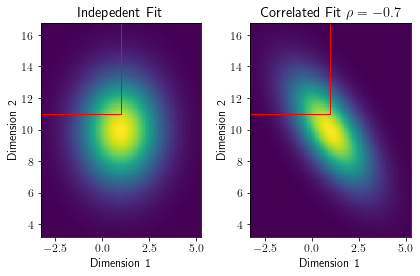

In [7]:
# Generate grid points

from scipy.stats import multivariate_normal
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 12})
from matplotlib import patches
mu = np.array([1, 10])
cmat = np.array([[2,0],[0,5]])
cov = np.sqrt(cmat[0,0])*np.sqrt(cmat[1,1])*-0.7
cmat[0,1] = cov; cmat[1,0] = cov
mvn = multivariate_normal(mean = mu, cov = np.diag(np.diag(cmat)))
mvn_corr = multivariate_normal(mean = mu, cov=cmat)
add_x, add_y = (3*np.sqrt(cmat[i,i]) for i in range(2))
x, y = np.meshgrid(np.linspace(mu[0]-add_x,mu[0]+add_x, 100),np.linspace(mu[1]-add_y,mu[1]+add_y,100))
xy = np.column_stack([x.flat, y.flat])

# density values at the grid points
Z = mvn.pdf(xy).reshape(x.shape)
Z_corr = mvn_corr.pdf(xy).reshape(x.shape)

# arbitrary contour levels
contour_level = [0.01, 0.02, 0.05]
fig, ax = plt.subplots(1,2)
ax_labels = ["Dimension 1", "Dimension 2"]
ctf = ax[0].pcolormesh(x, y, Z, shading='auto')#levels = contour_level,color='b')
ax[0].set_title("Indepedent Fit")
ct2 = ax[1].pcolormesh(x, y, Z_corr, shading='nearest')
ax[1].set_title("Correlated Fit $\\rho=-0.7$")
for i in range(2):
    ax[i].set_xlabel(ax_labels[0]); ax[i].set_ylabel(ax_labels[1])

rect = patches.Rectangle((2, 12), 40, 30, linewidth=1, edgecolor='r', facecolor='none')
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()

for i in range(2):
    rect = patches.Rectangle((1, 11), -40, 30, linewidth=1, edgecolor='r', facecolor='none')
    ax[i].add_patch(rect)
    ax[i].set_xlim(xlim); ax[i].set_ylim(ylim)
fig.tight_layout()

# Estimate the probability of doing 
def estimate_prob_rect(dist, x_bounds = [-np.inf, 1], y_bounds = [11,np.inf], n_mc_samples=100000):
    mc_sims = dist.rvs(n_mc_samples)
    mask_x = np.logical_and(mc_sims[:,0]>x_bounds[0], mc_sims[:,0]<x_bounds[1]) 
    mask_y = np.logical_and(mc_sims[:,1]>y_bounds[0], mc_sims[:,1]<y_bounds[1])
    return np.sum(np.logical_and(mask_x, mask_y))/n_mc_samples
display(estimate_prob_rect(mvn_corr))
display(estimate_prob_rect(mvn))

fig.savefig("../Images/IllustrativeExample.pdf")

In [3]:
rect.xy

(0.6931471805599453, 11)